In [2]:
import os
import sys
sys.path.append(f"{os.environ['base']}Tools")

import btk
import cv2 as cv
import dataset_generators as dgen
import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from PIL import Image, ImageDraw
from tensorflow import keras
from tensorflow.keras import layers

tf.config.experimental.set_memory_growth(tf.config.experimental.list_physical_devices('GPU')[0], True)
plt.style.use(f"{os.environ['style']}")


In [ ]:
#Demo set
dtimg = dgen.bg_words(1, 1, dgen.trainfonts)
dtx, dty = dgen.binary_text(dtimg, True)
display(Image.fromarray(dtimg[0][0]))

for x in range(len(dtx)):
    display(Image.fromarray(dtx[x]))
    display(dty[x])

In [2]:
trainx, trainy, valx, valy = btk.depickler('trainx-1643630773', 'trainy-1643630773', 'valx-1643630773', 'valy-1643630773', 'ocr')

""" trainx, trainy = dgen.binary_text(dgen.bg_words(13000, 1, dgen.trainfonts), True)
valx, valy = dgen.binary_text(dgen.bg_words(4500, 1, dgen.evalfonts), False)
num = btk.pickle_set(trainx, trainy, valx, valy, 'ocr') """

" trainx, trainy = dgen.binary_text(dgen.bg_words(13000, 1, dgen.trainfonts), True)\nvalx, valy = dgen.binary_text(dgen.bg_words(4500, 1, dgen.evalfonts), False)\nnum = btk.pickle_set(trainx, trainy, valx, valy, 'ocr') "

In [ ]:
tgen = btk.DataGen(trainx, trainy, 96)
vgen = btk.DataGen(valx, valy, 32)


opti = keras.optimizers.Adam(learning_rate=0.001)

inlay = keras.Input(shape=(32, 32, 1))
x = layers.Rescaling(1.0/255)(inlay)
x = layers.Conv2D(16, 3, padding='same', activation='relu')(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.Dropout(0.12)(x)
x = layers.Conv2D(32, 3, padding='same', activation='relu')(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.Dropout(0.12)(x)
x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.Dropout(0.12)(x)
x = layers.Flatten()(x)
x = layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0001))(x)
x = layers.Dropout(0.32)(x)
x = layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0001))(x)
outlay = layers.Dense(1, activation='sigmoid')(x)


log_dir = "tblogs/detector/v2-l/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tbcall = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
estop = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=20, restore_best_weights=True)

tdetect = keras.Model(inlay, outlay, name='tdetect')
tdetect.compile(optimizer=opti, loss='binary_crossentropy', metrics=['accuracy'])

history = tdetect.fit(
    x = tgen,
    validation_data=vgen,
    epochs=100,
    steps_per_epoch=20,
    validation_steps=20,
    callbacks=[estop, tbcall],
    verbose=0,
    shuffle=True
)

hist = pd.DataFrame(history.history)
hist[['accuracy', 'val_accuracy']].plot()
display(hist['val_accuracy'].max())
display(hist['val_loss'].min())

In [10]:
#tdetect.save('models\\tdetect-ss')
tdetect.summary()

Model: "tdetect"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_66 (InputLayer)       [(None, 32, 32, 1)]       0         
                                                                 
 rescaling_65 (Rescaling)    (None, 32, 32, 1)         0         
                                                                 
 conv2d_233 (Conv2D)         (None, 32, 32, 32)        320       
                                                                 
 max_pooling2d_221 (MaxPooli  (None, 16, 16, 32)       0         
 ng2D)                                                           
                                                                 
 dropout_286 (Dropout)       (None, 16, 16, 32)        0         
                                                                 
 conv2d_234 (Conv2D)         (None, 16, 16, 64)        18496     
                                                           

In [9]:
tdetect = tf.keras.models.load_model('models\\tdetect-ms')


def predictor(img: Image, dims: tuple[int, int], step: tuple[int, int], sensitivity: float = 0.95) -> list:
    slices, slice_coords = btk.img_slicer(img, dims, step, 'm')
    answers = tdetect.predict(btk.DataGen(slices))
    answer_coords = [list(slice_coords[x]) for x in range(len(answers)) if answers[x] > sensitivity]
    return answer_coords

def predict(img: Image, dims: tuple, sdims: tuple, step: int, sens: float, olr:float) -> list:
    resized = btk.img_splitter(img, dims, sdims)
    ygap = int(sdims[0] / 2)
    xgap = int(sdims[1] / 2)
    sum_coords = []
    for x in resized:
        text_coords = predictor(x, sdims, step, sens)
        for y in text_coords:
            sum_coords.append(y)
    predictions = coord_split(sum_coords, ygap, xgap, olr)
    return predictions

def drawbox(img: Image, coords: list) -> Image:
    for x in coords:
        ImageDraw.Draw(img).rectangle((x[2], x[0], x[3], x[1]), outline=122, width=1)
    return img

def detected_heat(img: Image, dims:tuple[int, int], sdims: tuple, step: int, sens:float)-> Image: 
    heatmap = np.zeros(dims, dtype=np.uint8)
    resized = btk.img_splitter(img, dims)
    for x in resized:
        text_coords = predictor(x, sdims, step, sens)
        yscale, xscale = dims[0] / x.shape[0], dims[1] / x.shape[1]
        scaled_coords = [[round(z[0] * yscale), round(z[1] * yscale), round(z[2] * xscale), round(z[3] * xscale)] for z in text_coords]
        for z in scaled_coords:
            heatmap[z[0]:z[1], z[2]:z[3]] = heatmap[z[0]:z[1], z[2]:z[3]] + np.ones((z[1] - z[0], z[3] - z[2]))
    return Image.fromarray(heatmap)

def extractor(img, coords):
    imarr = np.array(img)
    extracted = [imarr[x[0]:x[1], x[2]:x[3]] for x in coords]
    return extracted


def coord_sort(cords):
    temp1 = []
    temp2 = []
    temp3 = []
    for i, x in enumerate(cords):
        if x == cords[-1]:
            break
        while x[1] != cords[i + 1][0] or x[3] < cords[i + 1][2] or cords[i + 1][3] < x[2]:
            temp1.append(cords.pop(i + 1))
            if x == cords[-1]:
                break
    for i, x in enumerate(temp1):
        if x == temp1[-1]:
            break
        while x[1] != temp1[i + 1][0] or x[3] < temp1[i + 1][2] or temp1[i + 1][3] < x[2]:
            temp2.append(temp1.pop(i + 1))
            if x == temp1[-1]:
                break
    for i, x in enumerate(temp2):
        if x == temp2[-1]:
            break
        while x[1] != temp2[i + 1][0] or x[3] < temp2[i + 1][2] or temp2[i + 1][3] < x[2]:
            temp3.append(temp2.pop(i + 1))
            if x == temp2[-1]:
                break
    final = [*cords, *temp1, *temp2, *temp3]
    return final

def coord_split(coords: list, ygap: int, xgap: int, olr) -> list:
    split_coords = []
    for x in coords:
        split_coords.append((x[0], x[0] + ygap, x[2], x[2] + xgap))
        split_coords.append((x[0] + ygap, x[1], x[2] + xgap, x[3]))
        split_coords.append((x[0], x[0] + ygap, x[2], x[2] + xgap))
        split_coords.append((x[0] + ygap, x[1], x[2] + xgap, x[3]))
    split_coords = [x for x in btk.count(split_coords)]
    split_coords = [x[0] for x in split_coords if x[1] >= round(max([x[1] for x in split_coords]) * olr)]
    return split_coords

def is_touch(cord1: tuple, coords:list[tuple]) -> list:
    temp = set()
    for x in coords:
        if cord1[3] < x[2] or x[3] < cord1[2] or cord1 == x:
            pass
        elif cord1[0] != x[1] and cord1[1] != x[0]:
            pass
        else:
            temp.add(x)
    return list(temp)

def hbox_combo(coords: list, gap: int) -> list:
    y_rows = {x[0] for x in coords}
    row_boxes = []
    for x in y_rows:
        tmp1 = {i for i in coords if i[0] == x}
        tmp2 = {j[2]:j[3] for j in tmp1}
        while tmp2:
            start = min(tmp2.keys())
            stop = tmp2.get(start)
            tmp2.pop(start)
            found = True
            while found:
                if stop in tmp2.keys():
                    old = stop
                    stop = tmp2.get(stop)
                    tmp2.pop(old)
                elif stop + gap in tmp2.keys():
                    old = stop + gap
                    stop = tmp2.get(stop + gap)
                    tmp2.pop(old)
                else:
                    found = False
                    row_boxes.append((x, x + gap, start, stop))
    return row_boxes

def vbox_combo(coords: list) -> list:
    touched = [x for x in coords if x[1] in [y[0] for y in coords] or x[0] in [z[1] for z in coords]]
    singles = [x for x in coords if x not in touched]
    tmp1 = touched.copy()
    full_boxes = []
    while tmp1:
        checked = set()
        tocheck = is_touch(tmp1[0], touched)
        checked.add(tmp1[0])
        while tocheck:
            if tocheck[0] not in checked:
                for x in is_touch(tocheck[0], touched):
                    if x not in checked:
                        tocheck.append(x)
                checked.add(tocheck[0])
                tocheck.pop(0)
            else:
                checked.add(tocheck[0])
                tocheck.pop(0)
        checked = coord_sort(list(sorted(checked)))
        temp = checked[0]
        tmp1.remove(checked[0])
        for x in checked[1:]:
            tmp1.remove(x)
            overlap = min(x[3], temp[3]) - max([x[2], temp[2]])
            if temp[1] == x[0] and ((overlap / (x[3] - x[2])) + (overlap / (temp[3] - temp[2]))) / 2 >= 0.7:
                temp = (temp[0], x[1], min([x[2], temp[2]]), max([x[3], temp[3]]))
            else:
                full_boxes.append(temp)
                temp = x
        full_boxes.append(temp)
    full_boxes.extend(singles)
    return full_boxes

def combine(coords: list, dims: tuple[int, int], trim: bool = False) -> list:
    gap = coords[0][3] - coords[0][2]
    rows = hbox_combo(coords, gap)
    rows = [x for x in rows if x[3] - x[2] > 32]
    rows.sort()
    boxes = vbox_combo(rows)
    extended = []
    for x in boxes:
        xfactor = round((x[3] - x[2]) * 0.05)
        yfactor = round((x[1] - x[0]) * 0.075)
        extended.append([x[0] - yfactor, x[1] + yfactor, x[2] - xfactor, x[3] + xfactor])
    for x in extended:
        if x[0] < 0:
            x[0] = 0
        if x[1] > dims[0]:
            x[1] = dims[0]
        if x[2] < 0:
            x[2] = 0
        if x[3] > dims[1]:
            x[3] = dims[1]
    if trim:
        extended = sorted(extended, key=lambda x: (x[1] - x[0]) * (x[3] - x[2]), reverse=True)[:round(len(extended) * 0.4)]
    return extended, rows


(1216, 1664)

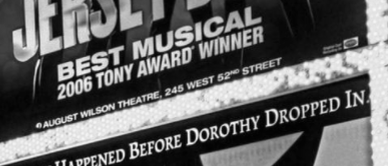

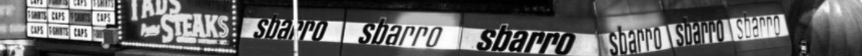

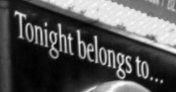

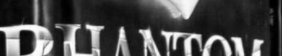

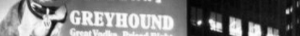

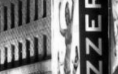

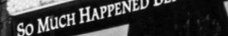

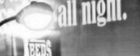

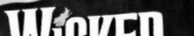

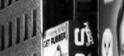

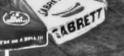

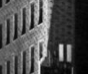

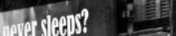

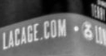

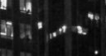

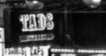

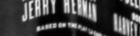

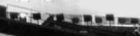

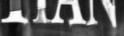

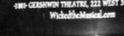

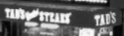

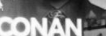

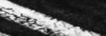

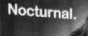

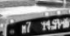

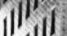

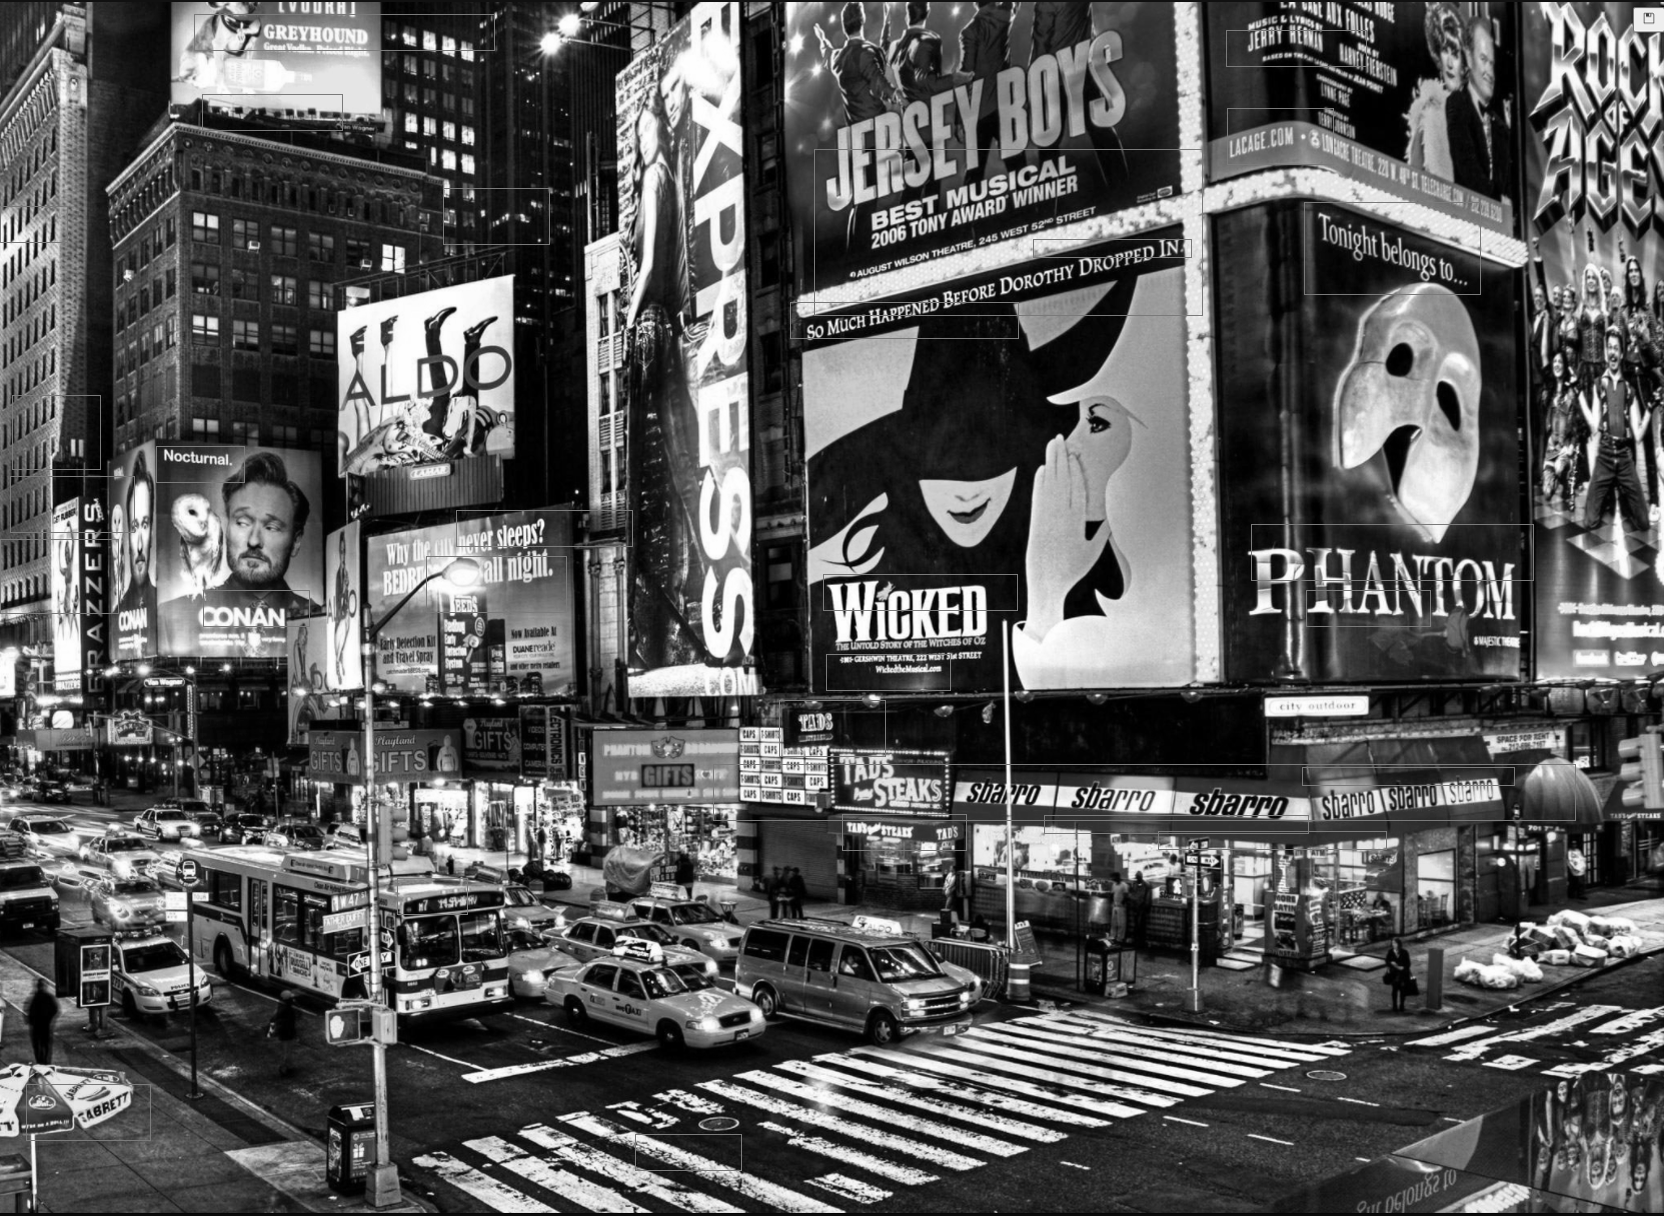

In [12]:
#with Image.open(f"{os.environ['base']}POE\\invite3.png") as ttt:
#    iar = btk.fit2dims((32, 32), btk.grey_np(ttt.crop((2050, 850, 2560, 1050)).copy()))
#    im = Image.fromarray(iar).resize((iar.shape[1] * 2, iar.shape[0] * 2))

#TODO Try standardization / normalization of data
with Image.open("testimgs\\t22.png") as f:
    iar = btk.fit2dims((32, 32), btk.grey_np(f))
    display(iar.shape)


""" im = Image.fromarray(iar).resize((iar.shape[1] * 2, iar.shape[0] * 2))
iar = np.array(im)
combined, rowed = combine(predict(im, iar.shape, (32, 32), (16, 16), 0.6, 0.4))
cuts = extractor(im, combined)
for x in cuts:
    display(Image.fromarray(x)) """

#im = Image.fromarray(iar)
#display(drawbox(im, rowed))
#im = Image.fromarray(iar)
#display(drawbox(im, combined))

#High  0.5, 0.3
#MH    0.6, 0.4
#Mid   0.7, 0.5
#ML    0.8, 0.6
#Low   0.9, 0.666

im = Image.fromarray(iar)
combined, rowed = combine(predict(im, iar.shape, (32, 32), (16, 16), 0.8, 0.5), iar.shape, True)
cuts = extractor(im, combined)
for x in cuts:
    display(Image.fromarray(x))

#im = Image.fromarray(iar)
#display(drawbox(im, rowed))
im = Image.fromarray(iar)
display(drawbox(im, combined))


In [ ]:
neat = heat.copy()
neat[neat < 4] = 0
#neat[neat > 2] = 10
neat = neat * 10

neat = cv.erode(neat, np.ones((5, 5), np.uint8), iterations = 2)
heat = cv.GaussianBlur(heat, (11, 11), 15)
neat = cv.erode(neat, np.ones((3, 3), np.uint8), iterations = 6)
heat = cv.GaussianBlur(heat, (7, 7), 15)
neat = cv.filter2D(neat, -1, btk.sharpenk)

display(im)
display(Image.fromarray(neat))

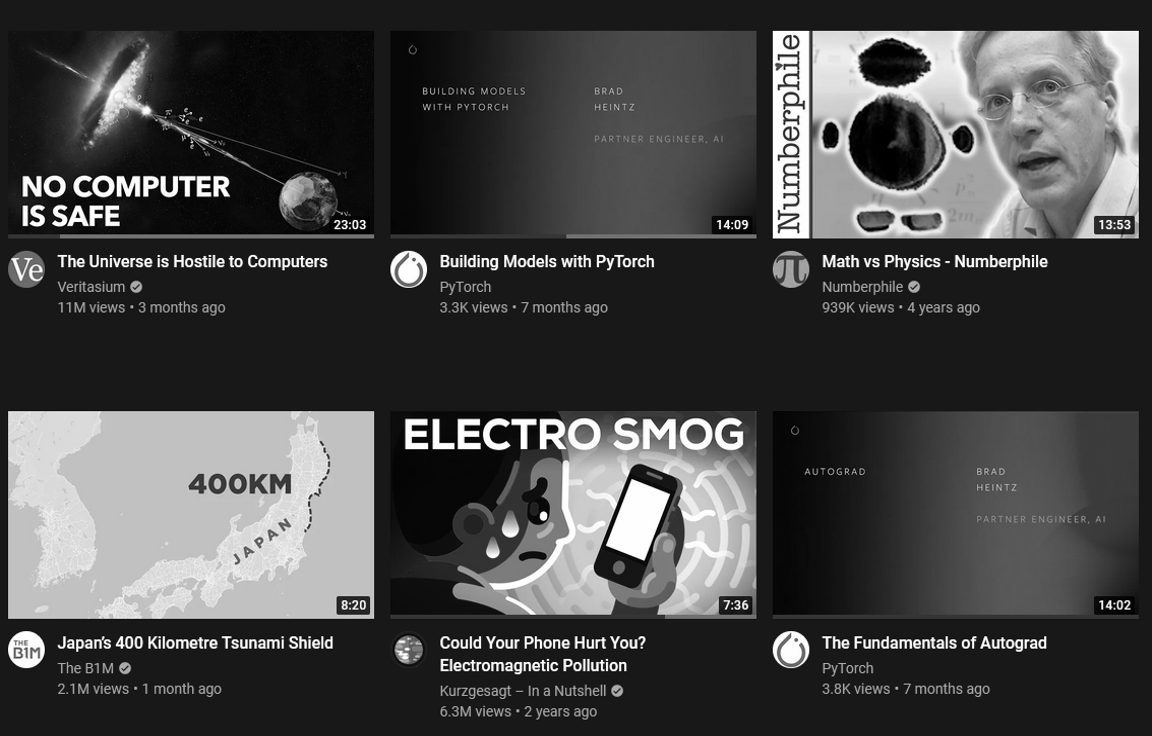

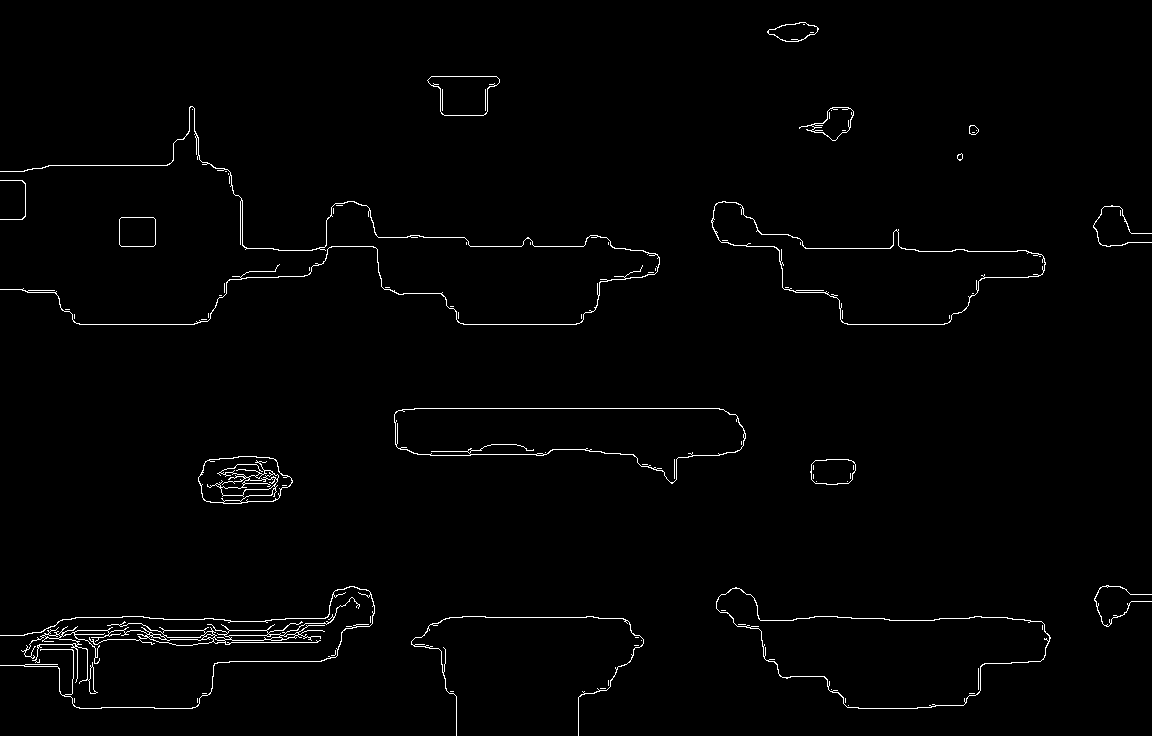

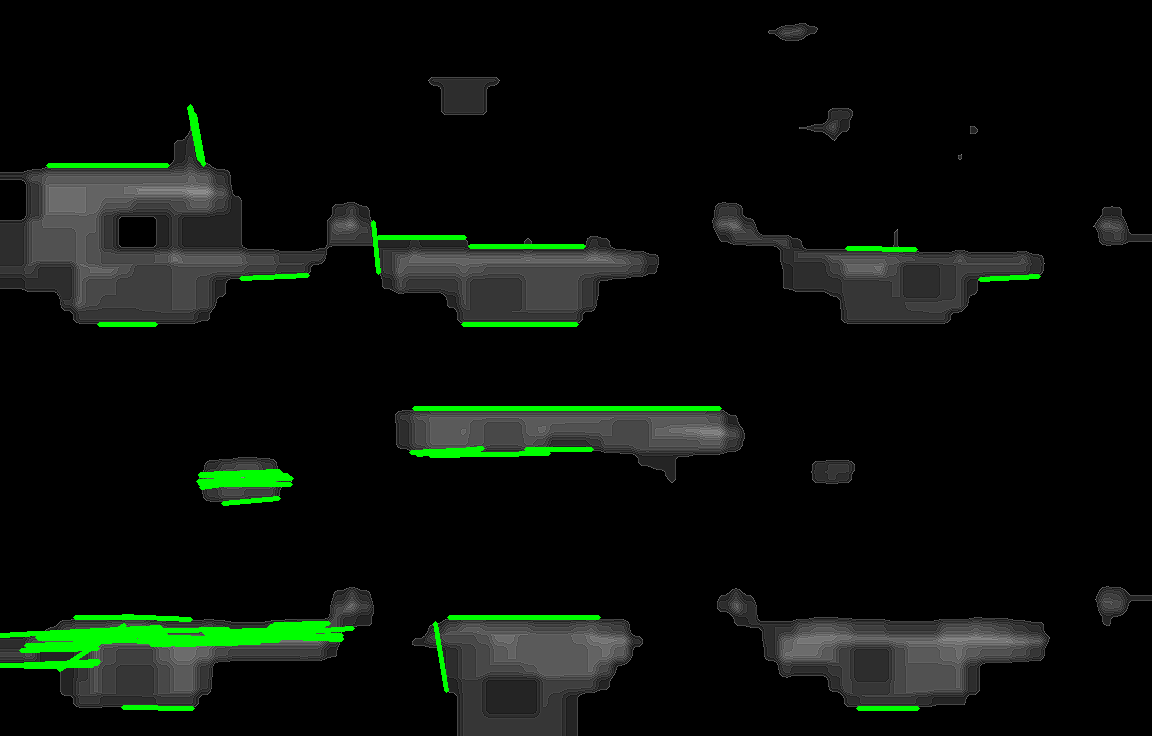

In [77]:
display(Image.fromarray(iar))
color = cv.cvtColor(neat, cv.COLOR_GRAY2RGB)
edges = cv.Canny(neat, 50, 200, apertureSize=3)
display(Image.fromarray(edges))
lines = cv.HoughLinesP(edges, 3, np.pi/180, 100, minLineLength=50, maxLineGap=25)
for x in lines:
    x1, y1, x2, y2 = x[0]
    cv.line(color, (x1, y1), (x2, y2), (0, 255, 0), 3)


display(Image.fromarray(color))

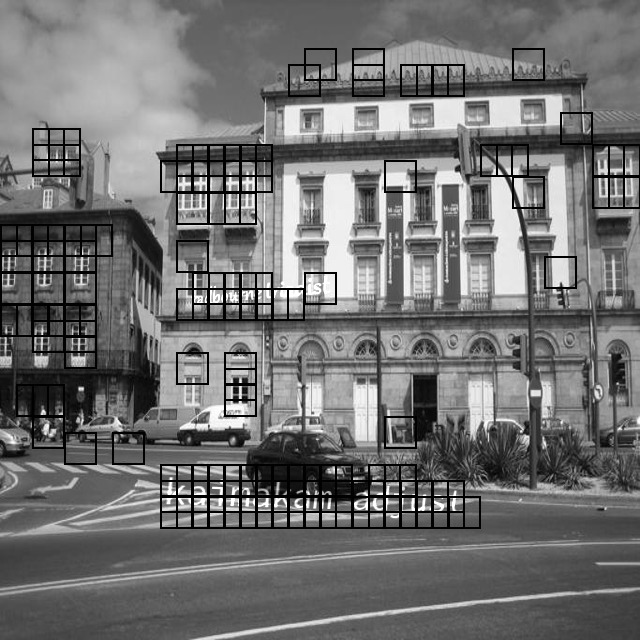

In [208]:
btestx = dgen.bg_words(1, 2, dgen.trainfonts)
test = Image.fromarray(btestx[0][0])

tsti, crds = btk.img_slicer(Image.fromarray(btestx[0][0]), (32, 32), (16, 16), 'm')
answers = istext_model.predict(btk.DataGen(tsti))
test = Image.fromarray(btestx[0][0])
test

drawbox(test, answers, crds, 0.80)[0]
#184, 248, 192, 416
#296, 360, 48, 256
